Download dữ liệu từ google drive

In [ ]:
!gdown --id 17teIlW1i6EsWD7UeuidsIlhdFwgC_PVK

Downloading...
From: https://drive.google.com/uc?id=17teIlW1i6EsWD7UeuidsIlhdFwgC_PVK
To: /content/process-data.zip
24.5MB [00:00, 67.3MB/s]


Tạo thư mục chứa dữ liệu và unzip tập dữ liệu từ drive tới thư mục vừa tạo

In [ ]:
!mkdir OriginalData
!mkdir data
!unzip "/content/process-data.zip" -d "/content/OriginalData"

Hàm xử lý đa luồng (thread)

In [ ]:
def threaded_generator(generator, num_cached=50):
    """Implements threaded generator to produce batches in background thread.
    # Arguments
        generator: an object exposing generator interface.
    # Yields
        Objects generated by generator.
    """
    from queue import Queue

    qu = Queue(maxsize=num_cached)
    sentinel = object()  # guaranteed unique reference

    # define producer (putting items into queue)
    def producer():
        for item in generator:
            qu.put(item)
        qu.put(sentinel)

    # start producer (in a background thread)
    import threading
    thread = threading.Thread(target=producer)
    thread.daemon = True
    thread.start()

    # run as consumer (read items from queue, in current thread)
    item = qu.get()
    while item is not sentinel:
        yield item
        qu.task_done()
        item = qu.get()

Import các thư viện cần thiết

In [ ]:
import argparse
import numpy as np
from scipy.ndimage.interpolation import rotate
import cv2
from scipy import ndimage
from os.path import basename, join, exists
from os import makedirs
from time import time
import sys
np.random.seed(13)

DEFAULT_INPUT_DIR = "/content/OriginalData"
DEFAULT_PREPROCESSED_ROOT = "/content/processed_data/train_data/Inception-400"
AUGMENTATIONS_PER_IMAGE = 50
BATCH_SIZE = 16
NUM_CACHED = 160

Hàm đọc file từ folder. Từ phiên bản 3.5 trở lên thì glob hỗ trợ đọc theo cây thư mục từ thư mục cha.

In [ ]:
def recursive_glob(root_dir, file_template="*.jpg"):
    """Traverse directory recursively. Starting with Python version 3.5, the glob module supports the "**" directive"""

    if sys.version_info[0] * 10 + sys.version_info[1] < 35:
        import fnmatch
        import os
        matches = []
        for root, dirnames, filenames in os.walk(root_dir):
            for filename in fnmatch.filter(filenames, file_template):
                matches.append(os.path.join(root, filename))
        return matches
    else:
        import glob
        return glob.glob(root_dir + "/**/" + file_template, recursive=True)

Hàm rút trích đặc trưng và gom đặc trưng của 20 bức ảnh được cắt ban đầu thành một đặc trưng chung

In [ ]:
def norm_pool(features, p=3):
    """Performs descriptor pooling
    # Arguments
        features: Numpy array of descriptors.
        p: degree of pooling.
    # Returns
        Numpy array of pooled descriptor.
    """
    return np.power(np.power(features, p).mean(axis=0), 1/p)


def encode(crops, model):
    """Encodes crops
    # Arguments
        crops: Numpy array of crops.
        model: Keras encoder.
    # Returns
        Numpy array of pooled descriptor.
    """
    features = model.predict(crops)
    pooled_features = norm_pool(features)
    return pooled_features

Hàm cắt ảnh hạt điều từ ảnh gốc theo tỉ lệ 1:1 (ưu tiên kích cỡ lớn hơn) và resize ảnh về cỡ 400x400 từ kết quả sau khi dectection từ Yolo

In [ ]:
def get_crops(img, left, top, size=400):
    h, w, c = img.shape
    assert all([size < h, size < w])
    if (left+size) > w:
      left=left+size-w;
    if (top+size)>h:
      top=top+size-h
    crop = img[top: top + size, left: left + size].copy()
    dsize = (400, 400)

    # resize image
    output = cv2.resize(crop, dsize)
    return output

Từ một bức ảnh gốc ảnh được genarate ra thành 20 bức ảnh và xoay (từ -359 tới 359 độ), lật lên xuống, trái phải nếu random có giá trị lớn hơn 0.5

In [ ]:
def get_rotation(img, n):
    rotates = []
    h, w, c = img.shape
    
    for _ in range(n):
      angleRandom=np.random.randint(-359, 359)
      rotated = rotate(img, angle=angleRandom, reshape=False)
      if np.random.random() > 0.5:
        rotated = np.flipud(rotated)
      if np.random.random() > 0.5:
        rotated = np.fliplr(rotated)
      h1, w1, c1=rotated.shape
      rotates.append(rotated)

    rotates = np.stack(rotates)
    assert rotates.shape == (n, 400, 400, c)
    return rotates

In [ ]:
def data_enhancement(image_file):
  img = cv2.imread(image_file)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  images_rotation = get_rotation(img, 20)
  yield images_rotation

Hàm rút trích đặc trưng

In [ ]:
def features_gen(rotation_and_output_file_, model): 
    ts = time()
    current_file = None
    pooled_features = []
    i = 0
    for j, (crops, output_file) in enumerate(rotation_and_output_file_):
        if current_file is None:
            current_file = output_file
        features = encode(crops, model)
        if output_file == current_file:
            pooled_features.append(features)
        else:
            np.save(current_file, np.stack(pooled_features))
            pooled_features = [features]
            current_file = output_file
            average_time = int((time() - ts) / (i + 1))
            print("Feature generator: {}, {} sec/image.".format(i + 1, average_time))
            i += 1
    if len(pooled_features) > 0:
        np.save(current_file, np.stack(pooled_features))

Hàm gọi tới hàm xoay và cắt ảnh

In [ ]:
def process_image(file_list):
  for i, (image_file, output_file) in enumerate(file_list):
        print("Image rotation generator:", i + 1)
        for rotated in data_enhancement(image_file):
            yield rotated, output_file

Khai báo lớp Inception từ thư viện keras và tiến hành thiết lập thông số ban đầu

In [ ]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input as preprocess_inception
from keras import backend as K
class Inception:
    __name__ = "Inception"

    def __init__(self, batch_size=32):
        self.model = InceptionV3(include_top=False, weights="imagenet", pooling="avg")
        self.batch_size = batch_size
        self.data_format = K.image_data_format()

    def predict(self, x):
        if self.data_format == "channels_first":
            x = x.transpose(0, 3, 1, 2)
        x = preprocess_inception(x.astype(K.floatx()))
        return self.model.predict(x, batch_size=self.batch_size)

Tải bộ trọng số *.npy đã được train trước đó về sử dụng

In [ ]:
if not exists(DEFAULT_PREPROCESSED_ROOT):
  makedirs(DEFAULT_PREPROCESSED_ROOT)
  !gdown --id 1CfSF4qZd-sArtVT7-zNZhb-e9-K2zeVc
  !unzip "/content/Inception-400.zip" -d "$DEFAULT_PREPROCESSED_ROOT"

Nếu đã download bộ tham số *.npy thì bỏ qua bước này

In [ ]:
INPUT_DIR =DEFAULT_INPUT_DIR
PREPROCESSED_ROOT = DEFAULT_PREPROCESSED_ROOT
input_files = recursive_glob(INPUT_DIR)
PREPROCESSED_PATH = join(PREPROCESSED_ROOT, "{}-400".format(Inception.__name__))
if not exists(PREPROCESSED_PATH):
  makedirs(PREPROCESSED_PATH)
model = Inception(batch_size=BATCH_SIZE)

output_files = [join(PREPROCESSED_PATH, basename(f).replace("jpg", "npy")) for f in input_files]
file_list = zip(input_files, output_files)

rotation_and_output_file = process_image(file_list)
rotation_and_output_file_ = threaded_generator(rotation_and_output_file, num_cached=NUM_CACHED)
features_gen(rotation_and_output_file_, model)

Hàm tạo fold để so sánh ở đây ta dùng 10 fold (Do số lượng dữ liệu train có hạn nên cần phương pháp này để đánh giá mô hình)

In [ ]:
import numpy as np
import glob
from os.path import basename, join
from sklearn.model_selection import StratifiedKFold
import pickle
import glob
def make_folds():
    """Creates stratified splits based on train directory listing
    # Dumps
        folds: list of splits dict{
                                   "train": {
                                               "x": train files list,
                                               "y": train labels},
                                   "test": {
                                               "x": test files list,
                                               "y": test labels}}
                                }
    """
    files = np.array([basename(f) for f in glob.glob(DEFAULT_PREPROCESSED_ROOT+"/*.npy")])
    labels = []
    classes = np.array([0, 1])
    for f in files:
        lb = np.array([f.startswith("c"),
                       f.startswith("k")])
        labels.append(classes[np.argmax(lb)])
    labels = np.array(labels)

    folds = []
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    for train_index, test_index in skf.split(files, labels):
        f_train, f_test = files[train_index], files[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        folds.append({"train": {"x": f_train, "y": y_train}, "test": {"x": f_test, "y": y_test}})
    if not exists('/content/data'):
      makedirs('/content/data')
    with open("data/folds-10.pkl", "wb") as f:
        pickle.dump(folds, f)

Hàm load dữ liệu từ mỗi fold sau đó chuyển thành tập train và test tại mỗi fold

In [ ]:
def load_data(in_dir, folds=None, split=None):
    """Builds train/test data from preprocessed features for a given split
    # Arguments
        in_dir: Input directory containing *.npy CNN feature files.
        folds: None or list of splits dict{
                                             "train": {
                                                         "x": train files list,
                                                         "y": train labels},
                                             "test": {
                                                         "x": test files list,
                                                         "y": test labels}}
                                        }
        split: None or split number.
    # Returns
        Tran/test data (features and labels) for a given split, if `folds` is not None
        Test data (only features) and file names, if `folds` is None
    """
    if folds:
        y_train = []
        x_train = []
        for f, l in zip(folds[split]["train"]["x"], folds[split]["train"]["y"]):
            x = np.load(join(in_dir, f))
            x_train.append(x)
            y_train.append([l] * len(x))
        x_train = np.vstack(x_train)
        y_train = np.concatenate(y_train)
        y_test = []
        x_test = []
        for f, l in zip(folds[split]["test"]["x"], folds[split]["test"]["y"]):
            x = np.load(join(in_dir, f))
            x_test.append(x)         
            y_test.append([l] * len(x))
        x_test = np.vstack(x_test)
        y_test = np.concatenate(y_test)

        return x_train, y_train, x_test, y_test
    else:
        files = glob.glob(in_dir + "/*.npy")
        x = []
        for f in files:
            x.append(np.load(f))
        return np.vstack(x), np.array([basename(f) for f in files])

Tạo fold

In [ ]:
make_folds()

In [ ]:
import pickle
import numpy as np
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from os.path import join, exists
from os import makedirs
import argparse

NUM_CLASSES = 2
RANDOM_STATE = 1
N_SEEDS = 5
VERBOSE_EVAL = False
with open("data/folds-10.pkl", "rb") as f:
    FOLDS = pickle.load(f)

LGBM_MODELS_ROOT = "models/LGBMs"
CROSSVAL_PREDICTIONS_ROOT = "predictions"

Hàm tính trung bình

In [ ]:
def _mean(x, mode="arithmetic"):
    """
    Calculates mean probabilities across augmented data
    # Arguments
        x: Numpy 3D array of probability scores, (N, AUGMENTATIONS_PER_IMAGE, NUM_CLASSES)
        mode: type of averaging, can be "arithmetic" or "geometric"
    # Returns
        Mean probabilities 2D array (N, NUM_CLASSES)
    """
    assert mode in ["arithmetic", "geometric"]
    if mode == "arithmetic":
        x_mean = x.mean(axis=1)
    else:
        x_mean = np.exp(np.log(x + 1e-7).mean(axis=1))
        x_mean = x_mean / x_mean.sum(axis=1, keepdims=True)
    return x_mean

Sử dụng SVM để phân lớp và đánh giá (Nếu nhận dạng 1 hạt điều cụ thể thì bỏ qua không cần chạy ô này)

In [ ]:
from sklearn import svm
INPUT_DATA_TRAIN = DEFAULT_PREPROCESSED_ROOT
def train_svm_model():
  model=svm.SVC(C=1.0, kernel='linear')
  for seed in range(N_SEEDS):
    accuracies = []
    avgStr=''
    for fold in range(len(FOLDS)):   
      x_train, y_train, x_test, y_test = load_data(INPUT_DATA_TRAIN, FOLDS, fold)
      train_data = model.fit(x_train, y_train)
      
      # pickle model
      model_file = "svm-{}-f{}-s{}.pkl".format("Inception-400", fold, seed)
      model_root = join(LGBM_MODELS_ROOT, "Inception-400")
      y_pred=model.predict(x_test)
      acc = accuracy_score(y_test, y_pred)
      accuracies.append(acc)
      avgStr=avgStr+'  [{:5.3}]'.format(acc)
      print('Accuracies: {}, mean={:5.3}'.format(avgStr, np.array(accuracies).mean()))
train_svm_model()

Accuracies:   [0.988], mean=0.988
Accuracies:   [0.988]  [0.976], mean=0.982
Accuracies:   [0.988]  [0.976]  [  1.0], mean=0.988
Accuracies:   [0.988]  [0.976]  [  1.0]  [  1.0], mean=0.991
Accuracies:   [0.988]  [0.976]  [  1.0]  [  1.0]  [  1.0], mean=0.993
Accuracies:   [0.988]  [0.976]  [  1.0]  [  1.0]  [  1.0]  [  1.0], mean=0.994
Accuracies:   [0.988]  [0.976]  [  1.0]  [  1.0]  [  1.0]  [  1.0]  [  1.0], mean=0.995
Accuracies:   [0.988]  [0.976]  [  1.0]  [  1.0]  [  1.0]  [  1.0]  [  1.0]  [0.975], mean=0.992
Accuracies:   [0.988]  [0.976]  [  1.0]  [  1.0]  [  1.0]  [  1.0]  [  1.0]  [0.975]  [  1.0], mean=0.993
Accuracies:   [0.988]  [0.976]  [  1.0]  [  1.0]  [  1.0]  [  1.0]  [  1.0]  [0.975]  [  1.0]  [  1.0], mean=0.994
Accuracies:   [0.988], mean=0.988
Accuracies:   [0.988]  [0.976], mean=0.982
Accuracies:   [0.988]  [0.976]  [  1.0], mean=0.988
Accuracies:   [0.988]  [0.976]  [  1.0]  [  1.0], mean=0.991
Accuracies:   [0.988]  [0.976]  [  1.0]  [  1.0]  [  1.0], mean=0

Thực hiện nhận dạng 1 hạt điều cụ thể

In [ ]:
if not exists("/content/test"):
    makedirs("/content/test")

Cắt và xoay 1 hạt điều đầu vào

In [ ]:
def process_one_image(image_file, output_file):
  for rotated in data_enhancement(image_file):
    yield rotated, output_file
        

Hàm dự đoán 1 hạt điều

In [ ]:
def predict_image(path):
  if not exists("/content/predicts"):
    makedirs("/content/predicts")
  rotation_and_output_file_1=process_one_image(path, "/content/predicts/test.npy")
  rotation_and_output_file_1 = threaded_generator(rotation_and_output_file_1, num_cached=NUM_CACHED)
  model = Inception(batch_size=BATCH_SIZE)
  features_gen(rotation_and_output_file_1, model)
  x1 = np.load("/content/predicts/test.npy")
  result=smv_model.predict(x1)
  if result==0:
    print('Hạt điều đạt chuẩn')
  else:
    print('Hạt điều không đạt chuẩn')

In [ ]:
from sklearn import svm
model=svm.SVC(C=1.0, kernel='linear')
if not exists(DEFAULT_PREPROCESSED_ROOT):
    makedirs(DEFAULT_PREPROCESSED_ROOT)

files = np.array([basename(f) for f in glob.glob(DEFAULT_PREPROCESSED_ROOT+"/*.npy")])
labels = []
x_train=[]
classes = np.array([0, 1])
for f in files:
  lb = np.array([f.startswith("c"), f.startswith("k")])
  labels.append(classes[np.argmax(lb)])
  x_train.append(np.load(DEFAULT_PREPROCESSED_ROOT+'/'+f))
labels = np.array(labels)
x_train= np.vstack(x_train)
smv_model = model.fit(x_train, labels)

Import darknet

In [ ]:
%cd /content/
!mkdir custom_yolov4
%cd custom_yolov4/
!git clone https://github.com/AlexeyAB/darknet

/content
/content/custom_yolov4
Cloning into 'darknet'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 14648 (delta 0), reused 2 (delta 0), pack-reused 14645
Receiving objects: 100% (14648/14648), 13.24 MiB | 27.95 MiB/s, done.
Resolving deltas: 100% (9970/9970), done.


Xóa file config và makefile mặc định của yolov4

In [ ]:
!rm -r /content/custom_yolov4/darknet/Makefile
!rm -r /content/custom_yolov4/darknet/cfg/yolov4-custom.cfg

Tải file config và yolo ta đã chỉnh tham số cho phù hợp

In [ ]:
%cd /content/custom_yolov4/darknet/
!gdown https://drive.google.com/uc?id=1FpnUnRwIIxnfkgC6w69ram8TeaFn5KCm
%cd /content/custom_yolov4/darknet/cfg/
!gdown https://drive.google.com/uc?id=1E8OHKVtBu1njACmhe5fYAoHZdlPmPNOH

/content/custom_yolov4/darknet
Downloading...
From: https://drive.google.com/uc?id=1FpnUnRwIIxnfkgC6w69ram8TeaFn5KCm
To: /content/custom_yolov4/darknet/Makefile
100% 5.66k/5.66k [00:00<00:00, 9.00MB/s]
/content/custom_yolov4/darknet/cfg
Downloading...
From: https://drive.google.com/uc?id=1E8OHKVtBu1njACmhe5fYAoHZdlPmPNOH
To: /content/custom_yolov4/darknet/cfg/yolov4-custom.cfg
100% 12.2k/12.2k [00:00<00:00, 18.4MB/s]


In [ ]:
# Step 5. Tạo file yolo.names
%cd /content/custom_yolov4/darknet
!echo "cashew" > yolo.names

/content/custom_yolov4/darknet


In [ ]:
# Step 7. Tạo file yolo.data
%cd /content/custom_yolov4/darknet
!mkdir backup
!echo classes=1 > yolo.data
!echo names=yolo.names >> yolo.data
!echo backup=backup >> yolo.data

/content/custom_yolov4/darknet


Tải 2 file đã custom là image.c và detector.c bỏ vào thư mục src của darknet

In [ ]:
%cd /content/custom_yolov4/darknet/src
!gdown https://drive.google.com/uc?id=1M8w-spGLKyxqV2__imzaNxwgzCNQpO8C
!gdown https://drive.google.com/uc?id=13FrW9KFtryc8EKXENqYy8aohoxGTNW8z

/content/custom_yolov4/darknet/src
Downloading...
From: https://drive.google.com/uc?id=1M8w-spGLKyxqV2__imzaNxwgzCNQpO8C
To: /content/custom_yolov4/darknet/src/detector.c
100% 76.8k/76.8k [00:00<00:00, 66.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=13FrW9KFtryc8EKXENqYy8aohoxGTNW8z
To: /content/custom_yolov4/darknet/src/image.c
100% 49.4k/49.4k [00:00<00:00, 43.5MB/s]


In [ ]:
%cd /content/custom_yolov4/darknet
if not exists("/content/custom_yolov4/darknet/output"):
    makedirs("/content/custom_yolov4/darknet/output")
with open('/content/custom_yolov4/darknet/output/boundingbox.json', 'w') as writefile:
    writefile.write("")
if not exists("/content/input"):
    makedirs("/content/input")
if not exists("/content/output"):
    makedirs("/content/output")
%cd /content/custom_yolov4/darknet

/content/custom_yolov4/darknet
/content/custom_yolov4/darknet


Load những hàm của thư viện yolo source viết bằng C lên bộ nhớ

In [ ]:
!make

Tải bộ trọng số detect hạt điều đã được train bằng yolo

In [ ]:
!cd /content/custom_yolov4/darknet/
!gdown https://drive.google.com/uc?id=1DuieYR5aDk9NhokS5C1mkCMMEiZMRjOx

Downloading...
From: https://drive.google.com/uc?id=1DuieYR5aDk9NhokS5C1mkCMMEiZMRjOx
To: /content/custom_yolov4/darknet/yolov4-custom_final.weights
256MB [00:01, 252MB/s]


Hàm show image đầu vào

In [ ]:
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

Hàm nhận dạng và khoanh vùng hạt điều, trả ra ảnh đã khoanh vùng và tọa  độ bounding box

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 700, cudnn_half = 0, GPU: Tesla V100-SXM2-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 32, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354

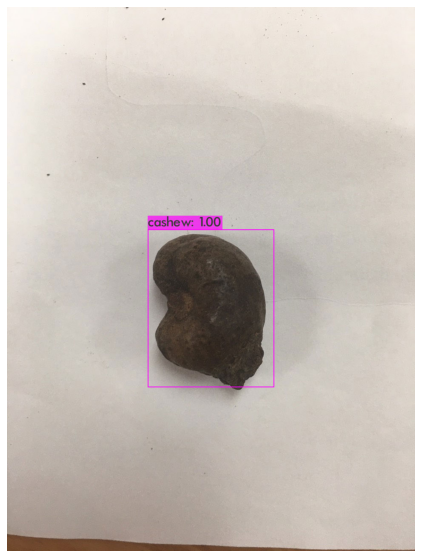

Hạt điều đã cắt phần trong bounding box


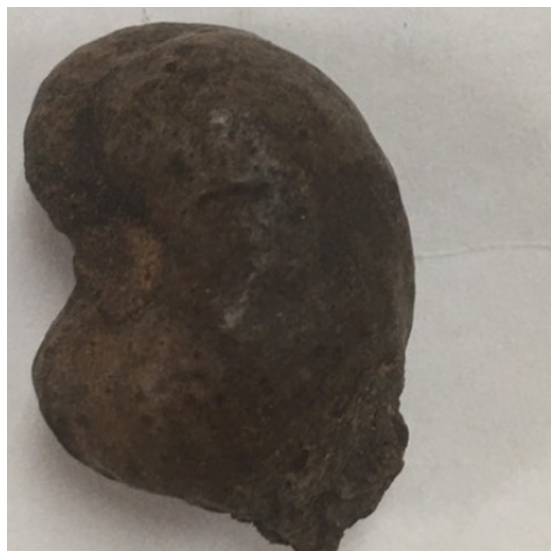

Loại hạt điều: 
Hạt điều đạt chuẩn


In [ ]:
import json

image_predict_path='/content/input/test3.jpg'

!cd /content/custom_yolov4/darknet/
!./darknet detector test yolo.data cfg/yolov4-custom.cfg yolov4-custom_final.weights -dont_show '$image_predict_path'
x1=0;x2=0;y1=0;y2=0;size=400
with open('/content/custom_yolov4/darknet/output/boundingbox.json') as json_file:
  data = json.load(json_file)
  x1=data['x1'];x2=data['x2']
  y1=data['y1'];y2=data['y2']

if (x2-x1)>(y2-y1):
  size=x2-x1
else:
  size=y2-y1

print('Hạt điều sử dụng object detection của YoloV4')
imShow('/content/custom_yolov4/darknet/output/predictions.jpg')
imgCrop = cv2.imread(image_predict_path)
imgCrop=get_crops(imgCrop, x1, y1, size)
cv2.imwrite('/content/output/crop.jpg', imgCrop)
print('Hạt điều đã cắt phần trong bounding box')
imShow('/content/output/crop.jpg')
print('Loại hạt điều: ')
predict_image("/content/output/crop.jpg")

